In [1]:
import json

def count_entries():
    # Path to the JSON file - adjust if needed
    file_path = "data/0_30_s_activitynetqa/0_30_s_activitynetqa_oe_qa_processed.json"
    
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
            
            # Check if data is a list or dictionary
            if isinstance(data, list):
                print(f"Number of entries: {len(data)}")
            elif isinstance(data, dict):
                print(f"Number of top-level keys: {len(data)}")
            else:
                print("Unexpected JSON structure")
                
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
    except json.JSONDecodeError:
        print("Error: Invalid JSON format")

if __name__ == "__main__":
    count_entries()

Number of entries: 2950


# Test decord

In [1]:
try:
    import av
    from decord import VideoReader, cpu
except ImportError:
    print("Please install pyav to use video processing functions.")
    
def process_video_with_decord(video_file, data_args):
    vr = VideoReader(video_file, ctx=cpu(0), num_threads=1)
    total_frame_num = len(vr)
    video_time = total_frame_num / vr.get_avg_fps()
    avg_fps = round(vr.get_avg_fps() / data_args.video_fps)
    frame_idx = [i for i in range(0, total_frame_num, avg_fps)]
    frame_time = [i/avg_fps for i in frame_idx]

    
    if data_args.frames_upbound > 0:
        if len(frame_idx) > data_args.frames_upbound or data_args.force_sample:
            uniform_sampled_frames = np.linspace(0, total_frame_num - 1, data_args.frames_upbound, dtype=int)
            frame_idx = uniform_sampled_frames.tolist()
            frame_time = [i/vr.get_avg_fps() for i in frame_idx]
    
    video = vr.get_batch(frame_idx).asnumpy()
    frame_time = ",".join([f"{i:.2f}s" for i in frame_time])

    num_frames_to_sample = num_frames = len(frame_idx)
    # https://github.com/dmlc/decord/issues/208
    vr.seek(0)
    return video, video_time, frame_time, num_frames_to_sample

In [ ]:
import os
import glob
import numpy as np

video_folder = "./data/0_30_s_activitynetqa/ActivityNet-QA"

# Get list of video files with common extensions recursively
video_extensions = ['.mp4', '.avi', '.mov', '.mkv', '.flv', '.webm']
video_files = [f for f in glob.glob(os.path.join(video_folder, '**/*.*'), recursive=True)
              if os.path.isfile(f) and 
              os.path.splitext(f)[1].lower() in video_extensions]

print(f"Found {len(video_files)} videos in directory")
print("Sample videos:", video_files[:3])  # Show first 3 as example

# Test video processing
class DataArgs:
    video_fps = 1
    frames_upbound = 8
    force_sample = False

success_count = 0
failure_count = 0

for i, video_path in enumerate(video_files[15:16]):  # Test first 5 videos
    try:
        video, duration, frame_times, num_frames = process_video_with_decord(video_path, DataArgs)
        print(f"Successfully processed: {i}, {os.path.basename(video_path)}")
        print(f"Sampled {num_frames} frames | Duration: {duration:.2f}s | Frame times: {frame_times}")
        success_count += 1
    except Exception as e:
        print(f"Error processing {i}, {os.path.basename(video_path)}: {str(e)}")
        failure_count += 1

print(f"\nTest results: {success_count} succeeded, {failure_count} failed")

Found 295 videos in directory
Sample videos: ['./data/0_30_s_activitynetqa/ActivityNet-QA/activitynet/train/v_YAm1JXAtqh4.mp4', './data/0_30_s_activitynetqa/ActivityNet-QA/activitynet/train/v_P5Sg_kACPRM.mp4', './data/0_30_s_activitynetqa/ActivityNet-QA/activitynet/train/v_7KYj4FQUESo.mp4']


[h264 @ 0x55d799543380] mmco: unref short failure
[h264 @ 0x55d799543380] mmco: unref short failure


Successfully processed: 0, v_lpeyMIH1YqA.mp4
Sampled 8 frames | Duration: 24.64s | Frame times: 0.00s,3.48s,7.00s,10.52s,14.04s,17.56s,21.08s,24.60s

Test results: 1 succeeded, 0 failed


In [22]:
video_files[14]

'./data/0_30_s_activitynetqa/ActivityNet-QA/activitynet/train/v_RP_PlV5Jzuc.mp4'

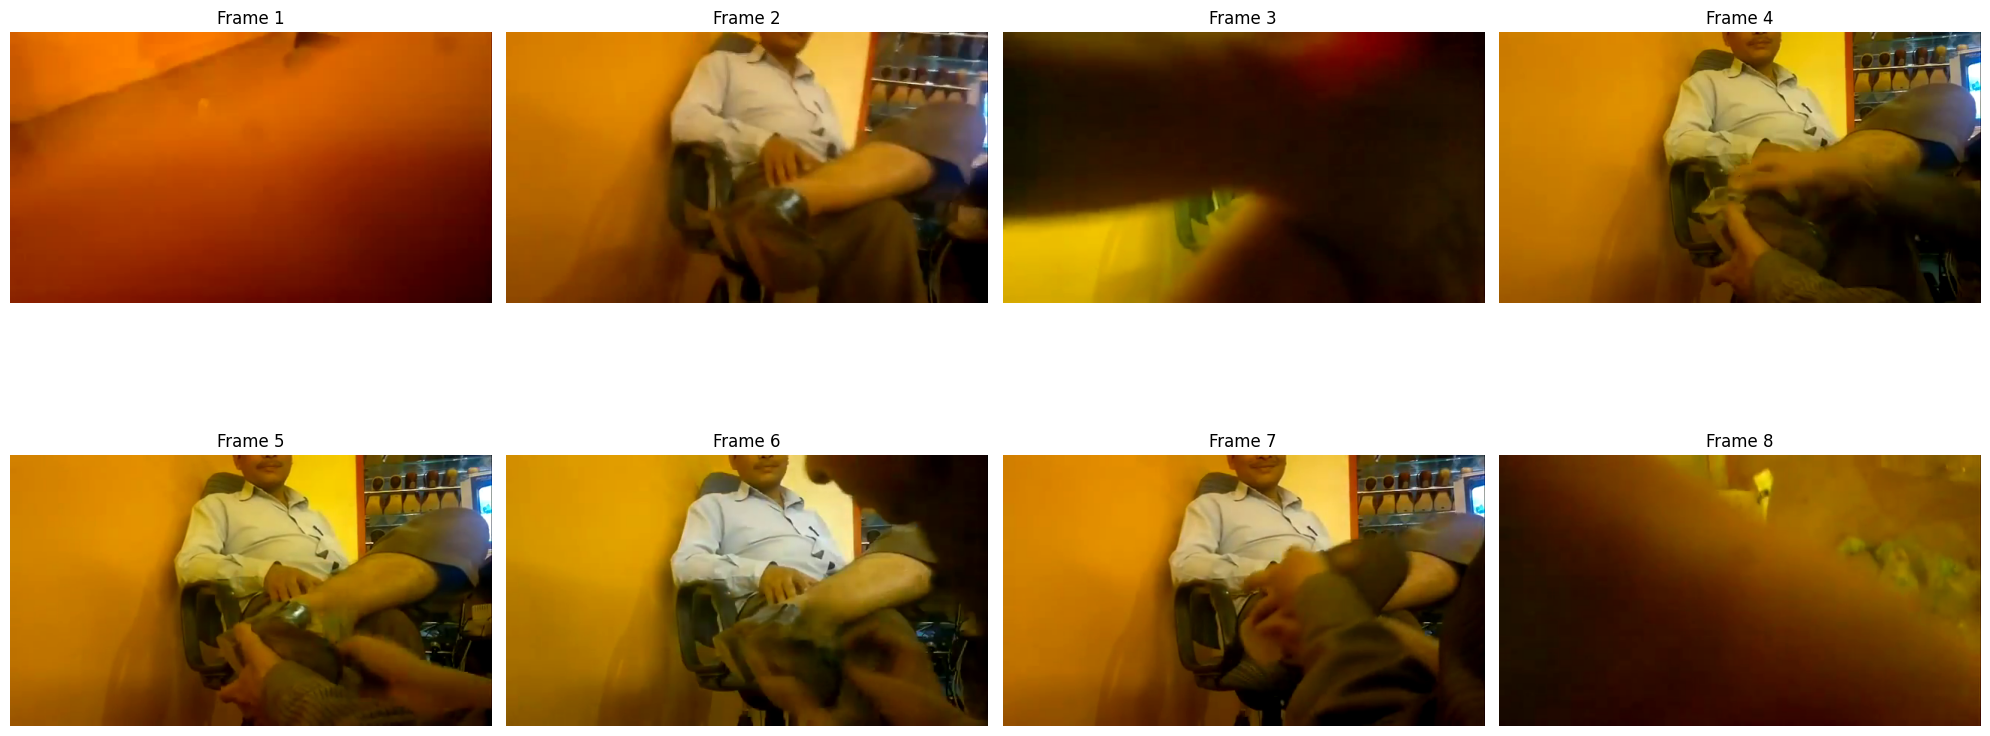

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming your video array is called 'video' and has shape (8, 360, 640, 3)
def display_video_frames(video):
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.ravel()
    
    for i in range(8):
        axes[i].imshow(video[i])
        axes[i].axis('off')
        axes[i].set_title(f'Frame {i+1}')
    
    plt.tight_layout()
    plt.show()

# To use this function:
display_video_frames(video)

# Split Train and Test Dataset

In [ ]:
import json
import random

data_path = "data/hualai_sft_data/full.json"

# Load data
with open(data_path, 'r') as f:
    data = json.load(f)

# Get all keys
keys = list(data.keys())

# Randomly shuffle keys
random.shuffle(keys)

# Calculate split point
split_point = int(len(keys) * 0.8)

# Split keys into train and test sets
train_keys = keys[:split_point]
test_keys = keys[split_point:]

# Create train and test dictionaries
train_data = {k: data[k] for k in train_keys}
test_data = {k: data[k] for k in test_keys}

# Save train data
with open('data/hualai_sft_data/train.json', 'w', encoding='utf-8') as f:
    json.dump(train_data, f, ensure_ascii=False, indent=2)

# Save test data
with open('data/hualai_sft_data/test.json', 'w', encoding='utf-8') as f:
    json.dump(test_data, f, ensure_ascii=False, indent=2)

print(f"Total samples: {len(data)}")
print(f"Training samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")

Total samples: 101
Training samples: 80
Test samples: 21


# Check the vocab size

In [3]:
import json
import os

model_dir = "/home/ec2-user/SageMaker/efs/Models/LLaVA-Video-7B-Qwen2"
# model_dir = "/home/ec2-user/SageMaker/efs/Projects/LLaVA-NeXT/checkpoints/llavanext-google_siglip-so400m-patch14-384-Qwen_Qwen2-7B-Instruct-ov_to_video_am9_aug17"
# model_dir = "/home/ec2-user/SageMaker/efs/Models/LLaVA-Video-72B-Qwen2"
model_name = model_dir.rsplit('/', 1)[1]
model_name = "LLaVA-Video-7B-Qwen2"

vocab_path = os.path.join(model_dir, 'vocab.json')
with open(vocab_path, 'r') as f:
    vocab = json.load(f)

max_v = 0
for k, v in vocab.items():
    max_v = max(max_v, v) 

max_v


151642